# P01 - Notebook - Exploration and modelisation

In [1]:
import gc
import imblearn as imb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

from lightgbm import LGBMClassifier

from lime import lime_tabular

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, recall_score, precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from xgboost import XGBClassifier

sns.set_theme()

import lib.kaggle_kernel as kaggle_kernel

C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Preprocessing using a Kaggle Kernel
For this part, we use the Kaggle kernel downloaded at this URL :
[https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)

In [2]:
# We run the whole kernel at once and retrieve a single file as an output
df = kaggle_kernel.preprocess(False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 31s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 42s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 19s
Installments payments df shape: (339587, 26)
Process installments payments - done in 47s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 44s


In [3]:
def get_model_data(
    df,
    min_fill=100,
    dropna=True,
    val_size=0.2,
    shuffle=True,
    random_state=None
):
    """ Returns a train, a validation and a competition datasets

    Args:
        :param df: (DataFrame) the output DF of the kaggle kernel
        :param min_fill: (int) the minimum fill percentage for feature
        :param dropna: (bool) whether to drop the NaN-containing features
        :param val_size: (float) the ratio of the dataset for the validation size
        :param shuffle: (bool) whether to shuffle the dataset
        :param random_state: (int) random state for the used models

    Returns:
        :return: 5 datasets : train_x, train_y, val_x, val_y, comp_x
    """
    # The competition DF is all the lines with no target
    test_df = df[df['TARGET'].isnull()]
    train_df = df[df['TARGET'].notnull()]

    # Keeping the features having the required minimum fill percentage
    fill_percentages = 100 * train_df.notnull().sum(axis=0) / len(train_df)
    features = fill_percentages.where(fill_percentages >= min_fill).dropna().index.tolist()
    train_df = train_df.filter(items=features, axis='columns')
    test_df = test_df.filter(items=features, axis='columns')

    # Removing the NaN values if asked
    if dropna:
        train_df.dropna(how='any', inplace=True)

    # Removing the useless feature
    X_train = train_df
    y_train = train_df['TARGET'].to_frame()

    # Renaming the columns to remove characters that GBM doesn't like
    X_train.columns = [re.sub("[^a-zA-Z0-9\s_]", "", f) for f in X_train.columns]
    test_df.columns = [re.sub("[^a-zA-Z0-9\s_]", "", f) for f in test_df.columns]

    # Spliting the train dataset into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=val_size,
        shuffle=shuffle,
        random_state=random_state
    )

    return X_train, y_train, X_val, y_val, test_df

In [ ]:
# We get the original dataset
X_train_imb, y_train_imb, X_val, y_val, test_df = get_model_data(df, min_fill=90)
print("Train size before isolation forest : {}".format(X_train_imb.shape))

# Let's try to remove the outliers using isolation forest
# We train the isolation forest algorithm
isof = IsolationForest()
isof_predictions = isof.fit_predict(X_train_imb)
isof_scores = pd.DataFrame(
    isof.score_samples(X_train_imb)
).rename(columns={0: 'isof_score'})

X_train_imb = pd.concat([
    X_train_imb.reset_index(),
    isof_scores
], axis=1).drop(labels=['index'], axis='columns')

y_train_imb = pd.concat([
    y_train_imb.reset_index(),
    isof_scores
], axis=1).drop(labels=['index'], axis='columns')

feats = [f for f in X_train_imb.columns if f not in [
    'TARGET',
    'SK_ID_CURR',
    'SK_ID_BUREAU',
    'SK_ID_PREV',
    'index',
    'isof_score',
    'level_0'
]]

export_feats_train = [f for f in X_train_imb.columns if f not in [
    'SK_ID_BUREAU',
    'SK_ID_PREV',
    'index',
    'isof_score',
    'level_0'
]]

export_feats_test = [f for f in X_train_imb.columns if f not in [
    'SK_ID_BUREAU',
    'SK_ID_PREV',
    'index',
    'isof_score',
    'level_0',
    'TARGET'
]]

# We export the whole train dataset for the dashboard with the target
X_train_imb[export_feats_train].sample(frac=0.10)\
    .to_csv('./application/dashboard/data/train_set.csv')
test_df[export_feats_test].sample(frac=0.30).to_csv('./application/dashboard/data/test_set.csv')

# We filter the outliers based on a threshold chosen by testing it
ISOLATION_FOREST_THRESHOLD = -0.47
X_train_imb = X_train_imb[X_train_imb['isof_score'] >= ISOLATION_FOREST_THRESHOLD][feats]
y_train_imb = y_train_imb[y_train_imb['isof_score'] >= ISOLATION_FOREST_THRESHOLD]['TARGET']

X_val = X_val[feats]

print("Train size after isolation forest : {}".format(X_train_imb.shape))

Train size before isolation forest : (227909, 443)


In [5]:
# Also creating a balanced dataset
# In a separate cell because the process can be long
oversample = imb.over_sampling.SMOTE(sampling_strategy=0.1)
undersample = imb.under_sampling.RandomUnderSampler(sampling_strategy=0.1)
X_train_bal, y_train_bal = oversample.fit_resample(X_train_imb, y_train_imb)
X_train_bal, y_train_bal = undersample.fit_resample(X_train_bal, y_train_bal)

print("Train size before balancing : {}".format(X_train_imb.shape))
print("Train size after balancing : {}".format(X_train_bal.shape))

Train size before balancing : (226280, 440)
Train size after balancing : (228613, 440)


## Completing preprocessing
### Filtering features

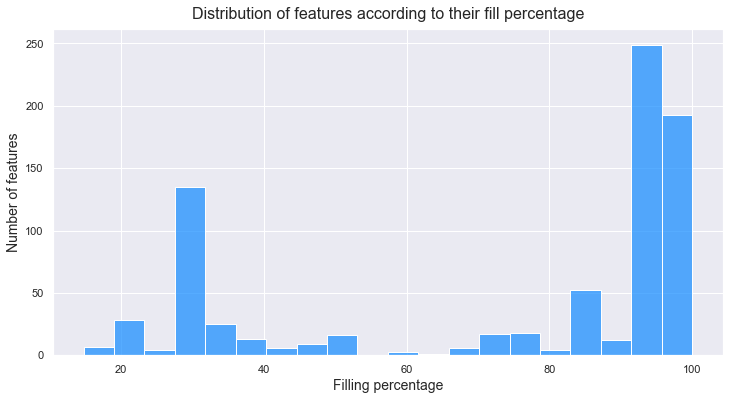

In [28]:
fill_percentages = 100 * df.notnull().sum(axis=0) / len(df)

plt.figure(figsize=(12, 6))
sns.histplot(fill_percentages, bins=20, color="dodgerblue")
plt.title("Distribution of features according to their fill percentage", fontsize=16, pad=10)
plt.xlabel("Filling percentage", fontsize=14)
plt.ylabel("Number of features", fontsize=14)
plt.show()

0.0    0.918495
1.0    0.081505
Name: TARGET, dtype: float64


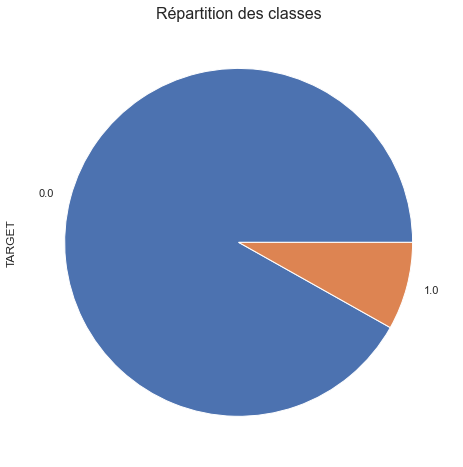

In [29]:
print(y_train_imb.value_counts() / len(y_train_imb))
plt.figure(figsize=(8, 8))
plt.title("Répartition des classes", fontsize=16)
y_train_imb.value_counts().plot(kind='pie')
plt.show()

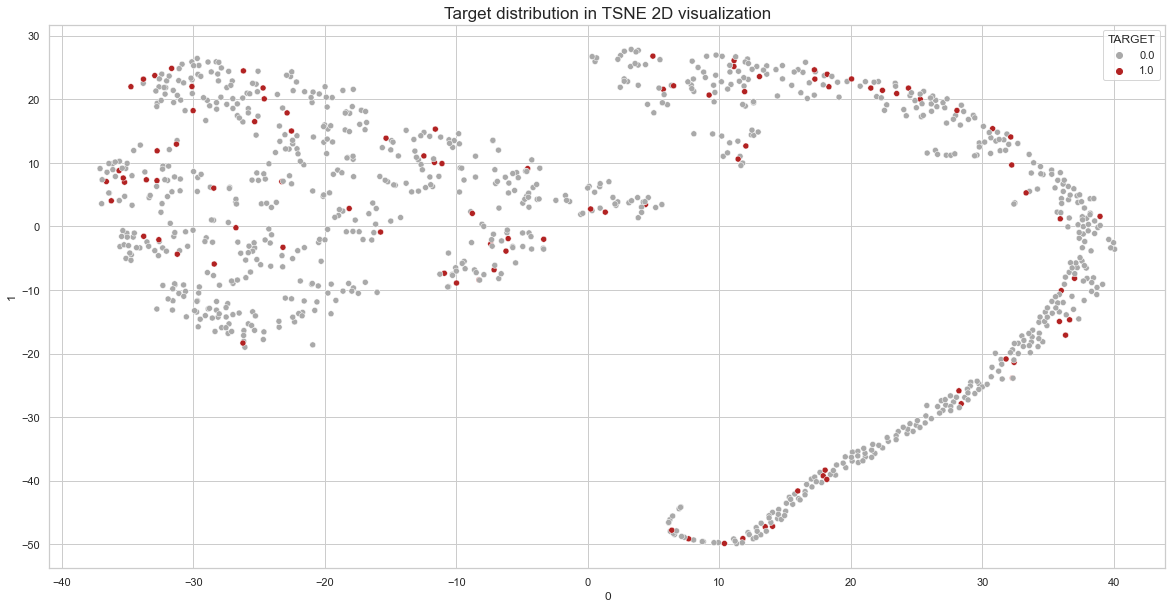

In [30]:
data_tsne = pd.concat([X_train_imb, y_train_imb], axis=1).sample(1000)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=700)
data_tsne_2d = tsne.fit_transform(data_tsne)

train_df_tsne = pd.concat([
    data_tsne.reset_index(),
    pd.DataFrame(data_tsne_2d).reset_index()
], axis=1)

plt.figure(figsize=(20,10))
plt.title("Target distribution in TSNE 2D visualization", fontsize=17)
sns.scatterplot(
    data=train_df_tsne,
    x=0,
    y=1,
    hue='TARGET',
    palette={1.0: 'firebrick', 0.0: 'darkgrey'},
)
plt.show()

# Selecting a model
## Testing models
In this part, we are going to test different models (default hyperparameters, on 20% of the
dataset).
Then we will keep the best one and optimize its hyperparameters, and check its scores on the
whole dataset.

In [7]:
def test_model(
    X_train,
    y_train,
    X_val,
    y_val,
    model,
    sample=None,
    random_state=None,
    n_splits=5,
    fit=None,
    verbose=True,
    avoid_features_importances=False,
    beta=2,
    threshold=0.5
):
    """
    Test a model using a stratified KFold and returns its scores

    Args:
        :param X_train: (DataFrame) the train data features
        :param y_train: (DataFrame) the train data target
        :param X_val: (DataFrame) the validation dataset
        :param y_val: (DataFrame) the validation data target
        :param model: the model to train and test
        :param sample: (int|float) the size of the sample to use for the train (default : all)
        :param random_state: (int) the random state for the shuffle
        :param n_splits: (int) number of splits into the kfolds
        :param fit: (string|None) a string defining which fit() method to use for the model
        :param verbose: (boolean) whether show the debug prints
        :param avoid_features_importances: (boolean) do not save feature importances (used for
        dummy classifier)
        :param beta: (integer) beta value for fbeta score calculation
        :param threshold: (float) beta value for fbeta score calculation

    Returns:
        :return: (tuple) (roc_auc_scores, roc_curve_values, feature_importance_df)
    """
    # Let's work on a sample if asked for shorter run times
    if type(sample) is float and sample <= 1.0:
        indexes = np.random.randint(0, len(X_train), int(sample * len(X_train)))
    elif type(sample) is int and sample > 0:
        indexes = np.random.randint(0, len(X_train), sample)
    else:
        indexes = range(0, len(X_train))

    feats = [f for f in X_train.columns if f not in [
        'TARGET',
        'SK_ID_CURR',
        'SK_ID_BUREAU',
        'SK_ID_PREV',
        'index',
        'isof_score'
    ]]

    X_train = X_train.iloc[indexes][feats]
    y_train = y_train.iloc[indexes]

    if verbose:
        print("Size of the training dataset : {} rows".format(X_train.shape[0]))

    # Cross validation model
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(X_train.shape[0])
    roc_auc_scores = []
    val_roc_auc_scores = []
    roc_curve_values = []
    val_roc_curve_values = []
    feature_importance_df = pd.DataFrame()
    fbeta_scores = []
    recalls = []

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        rf = clone(model)

        if fit == 'lgbm':
            print("LGBM Special fit")
            rf.fit(
                train_x,
                train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc',
                verbose= 200,
                early_stopping_rounds= 200
            )
        else:
            rf.fit(train_x, train_y)

        oof_preds[valid_idx] = rf.predict_proba(valid_x)[:, 1]
        validation_preds_proba = rf.predict_proba(X_val)[:, 1]
        validation_preds = validation_preds_proba > threshold

        if not avoid_features_importances:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["fold"] = n_fold + 1
            fold_importance_df["importance"] = rf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calcul des métriques
        roc_auc_scores.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
        val_roc_auc_scores.append(roc_auc_score(y_val, validation_preds_proba))
        fbeta_scores.append(fbeta_score(y_val, validation_preds, beta=beta))
        recalls.append(recall_score(y_val, validation_preds))

        if verbose:
            print('Fold %2d : AUC : %.6f | fbeta : %.6f | recall : %.6f' % (
                n_fold + 1,
                roc_auc_score(y_val, validation_preds_proba),
                fbeta_score(y_val, validation_preds, beta=beta),
                recall_score(y_val, validation_preds)
            ))
        roc_curve_values.append(roc_curve(valid_y, oof_preds[valid_idx]))
        val_roc_curve_values.append(roc_curve(y_val, validation_preds_proba))

        del rf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Finding the best fold
    max_auc_score = max(val_roc_auc_scores)
    max_index = val_roc_auc_scores.index(max_auc_score)

    if verbose:
        print("Mean ROC-AUC score = {}"
          .format(max_auc_score, max_index, np.mean(val_roc_auc_scores))
        )

    scores = {
        'roc_auc': val_roc_auc_scores,
        'fbeta': fbeta_scores,
        'recall': recalls
    }

    return scores, feature_importance_df, val_roc_curve_values, validation_preds_proba


def show_model_scores(y_true, y_proba):
    """ Plot the different scores of a model using its predictions

    Args:
        :param y_true: (list) the real values of the predictions
        :param y_proba: (list or DataFrame) the model probabilities
    """
    recalls_scores = []
    precision_scores = []
    roc_curve_values = []
    roc_auc_scores = []
    fbeta_scores = {}
    betas = range(1, 10, 2)

    # init
    for beta in betas:
        fbeta_scores[beta] = []

    for threshold in np.arange(0, 1.05, 0.05):
        predictions = probas > threshold
        recalls_scores.append(recall_score(y_true, predictions))
        precision_scores.append(
            precision_score(y_true, predictions) if np.sum(predictions) > 0 else None
        )
        roc_curve_values.append(roc_curve(y_true, y_proba))
        roc_auc_scores.append(roc_auc_score(y_true, y_proba))
        for beta in betas:
            fbeta_scores[beta].append(fbeta_score(y_true, predictions, beta=beta))

    fig, axes = plt.subplots(figsize=(16, 12), ncols=2, nrows=2)
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle("Evolution of metrics with threshold", fontsize=17, y=0.95)

    # First plot : evolution of precision / recall and f-beta scores with threshold
    axes[0][0].plot(recalls_scores, label="Recall", color='firebrick')
    axes[0][0].plot(precision_scores, label="Precision", color='green')
    axes[0][0].set_title("Evolution of recall and precision", fontsize=14, pad=10)
    axes[0][0].set_xticks(ticks=range(21), labels=[x/20 if x%2 == 0 else '' for x in range(21)])
    axes[0][0].legend(loc='lower right')

    # Second plot : PR curve
    axes[0][1].plot(recalls_scores, precision_scores)
    axes[0][1].set_title("Precision-Recall Curve", fontsize=14, pad=10)
    axes[0][1].set_xlabel("Recall")
    axes[0][1].set_ylabel("Precision")

    # Third plot : f-beta scores
    axes[1][0].plot(recalls_scores, label="Recall", color='grey', linestyle='dashed')
    axes[1][0].plot(precision_scores, label="Precision", color='grey', linestyle='dotted')
    for beta in betas:
        axes[1][0].plot(fbeta_scores[beta], label="f-{}".format(beta))
    axes[1][0].set_xticks(ticks=range(21), labels=[x/20 if x%2 == 0 else '' for x in range(21)])
    axes[1][0].set_title("Evolution of f-beta scores", fontsize=14, pad=10)
    axes[1][0].legend(loc='upper right')
    axes[1][0].set_xlabel("Threshold")

    # Fourth plot : ROC Curve
    mean_roc_score = np.mean(roc_auc_scores)
    axes[1][1].plot([0, 1], [0, 1], color='grey', linestyle='dashed')
    for roc_curve_val in roc_curve_values:
        axes[1][1].plot(roc_curve_val[0], roc_curve_val[1])
    axes[1][1].set_title(
        "ROC Curve (mean ROC = {})".format(round(mean_roc_score, 2)),
        fontsize=14,
        pad=10
    )
    axes[1][1].set_xlabel("1 - Specificity")
    axes[1][1].set_ylabel("Sensitivity")

    plt.show()

In [10]:
TEST_SAMPLE_SIZE=0.7

### Random Forest Classifier

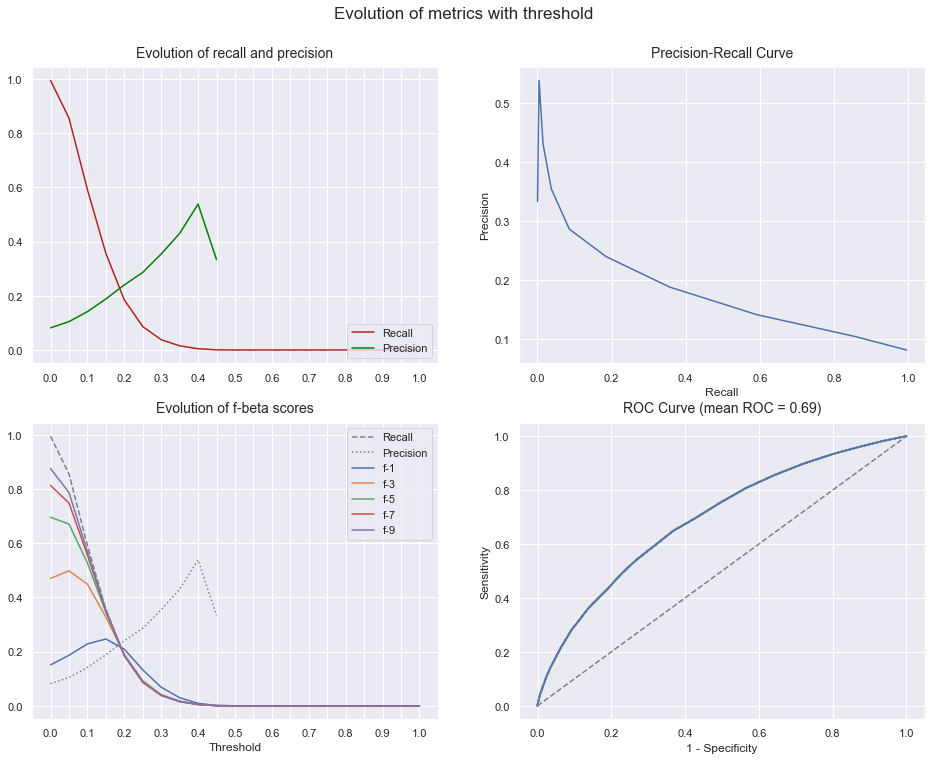

In [11]:
# Testing without target balancing
rf = RandomForestClassifier()
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_imb,
    y_train_imb,
    X_val,
    y_val,
    model=rf,
    sample=TEST_SAMPLE_SIZE,
    beta=1,
    threshold=0.5,
    verbose=False
)
show_model_scores(y_val, probas)

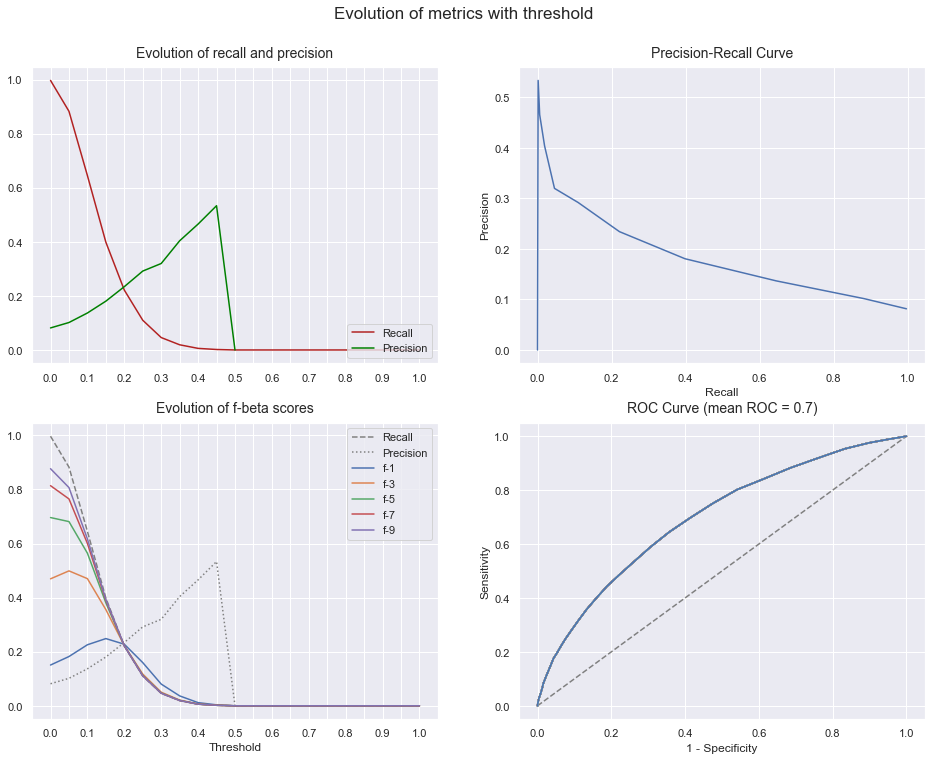

In [12]:
# Testing WITH target balancing
rf = RandomForestClassifier()
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_bal,
    y_train_bal,
    X_val,
    y_val,
    model=rf,
    sample=TEST_SAMPLE_SIZE,
    beta=1,
    threshold=0.5,
    verbose=False
)
show_model_scores(y_val, probas)

### LightGBM

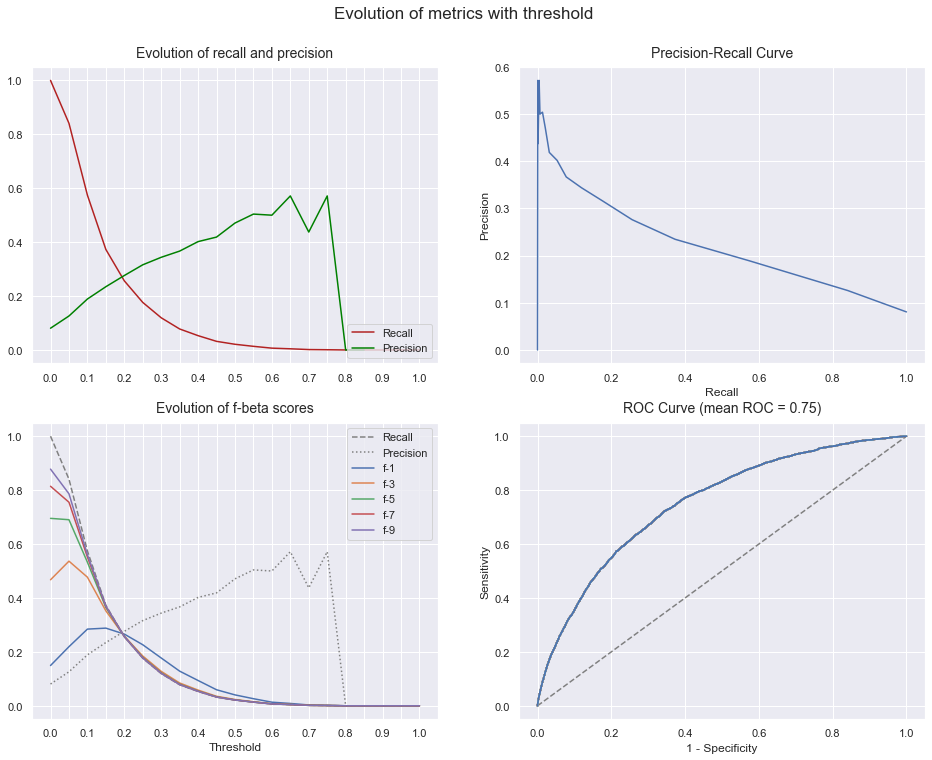

In [13]:
lgbm = LGBMClassifier()
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_imb,
    y_train_imb,
    X_val,
    y_val,
    model=lgbm,
    sample=TEST_SAMPLE_SIZE,
    beta=1,
    threshold=0.5,
    verbose=False
)
show_model_scores(y_val, probas)

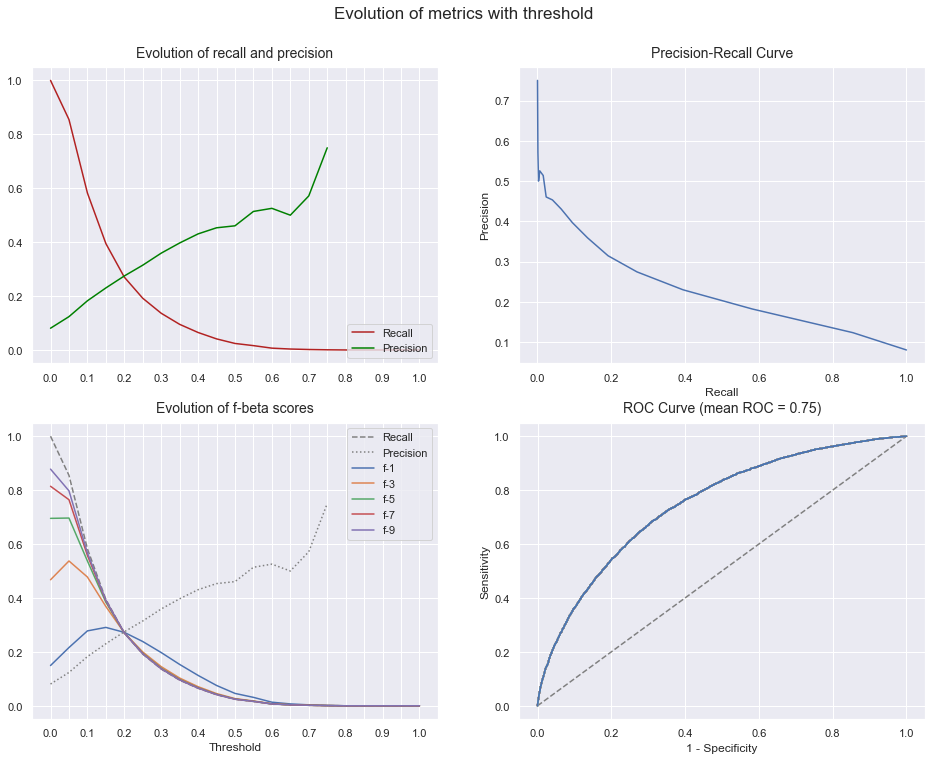

In [14]:
### LightGBM
lgbm = LGBMClassifier()

# the threshold wont be used
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_bal,
    y_train_bal,
    X_val,
    y_val,
    model=lgbm,
    sample=1.0,
    beta=1,
    threshold=0.5,
    verbose=False
)
show_model_scores(y_val, probas)

### XGBoost

C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


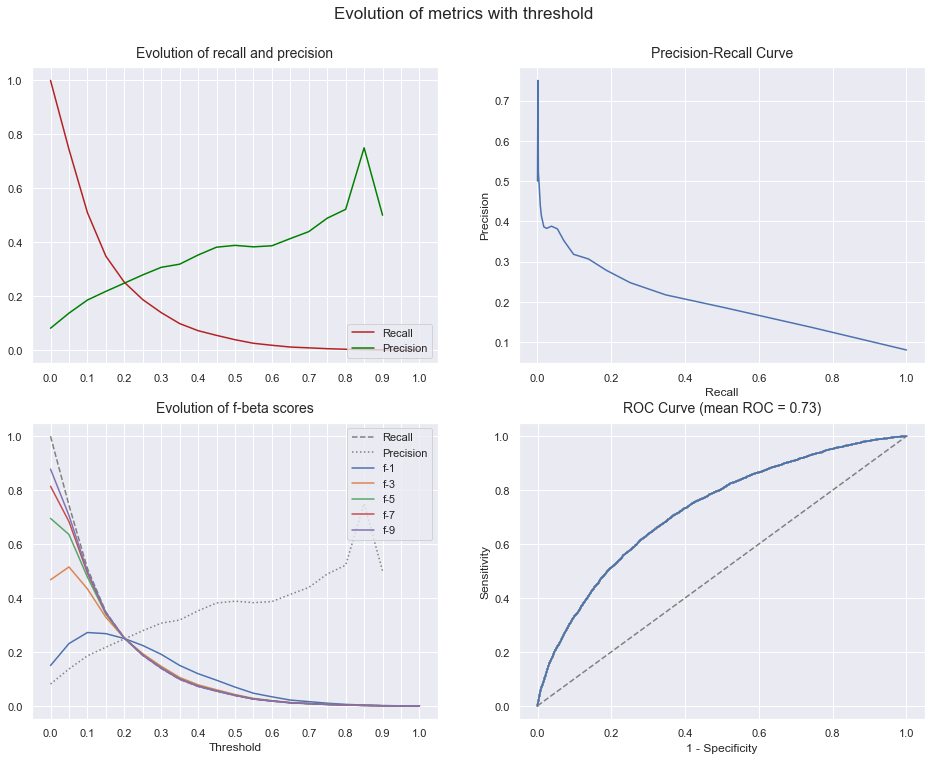

In [15]:
# Testing without target balancing
xgboost = XGBClassifier()
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_imb,
    y_train_imb,
    X_val,
    y_val,
    model=xgboost,
    sample=TEST_SAMPLE_SIZE,
    beta=1,
    threshold=0.5,
    verbose=False
)
show_model_scores(y_val, probas)

### Balanced data

C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\envs\oc_p7_pyth38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


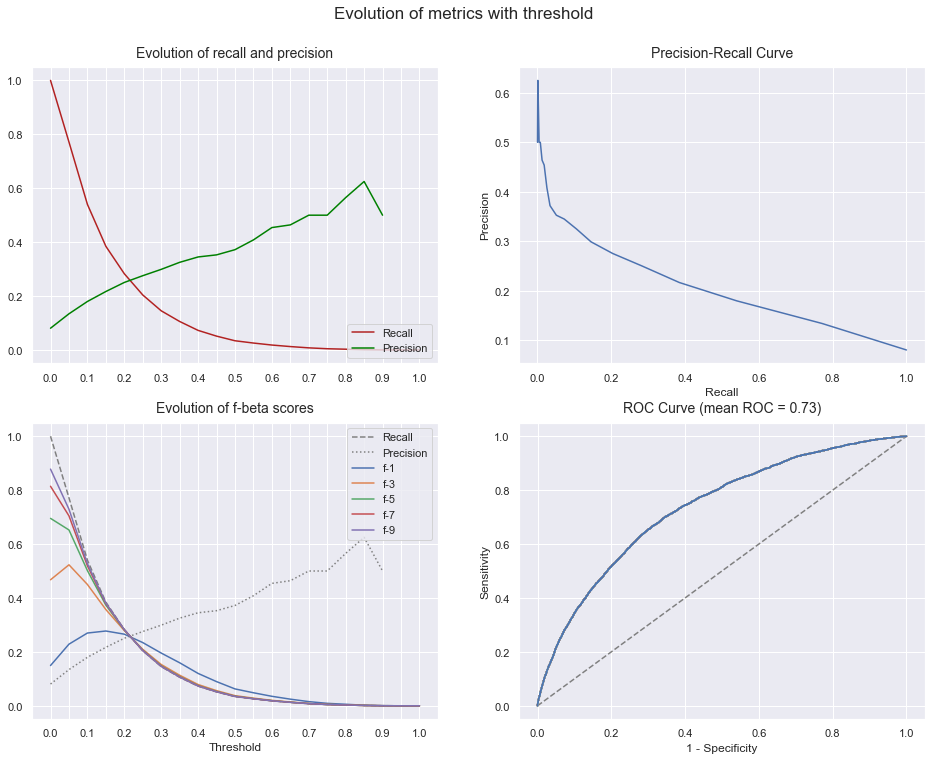

In [16]:
# Testing WITH target balancing
xgboost = XGBClassifier()
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_bal,
    y_train_bal,
    X_val,
    y_val,
    model=xgboost,
    sample=1.0,
    beta=1,
    threshold=0.5,
    verbose=False
)
show_model_scores(y_val, probas)

## Optimizing the best model (LightGBM)
Now we are using the BayesSearchCV in order to optimize our LightGBM best model.

In [127]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),        # Boosting learning rate
    'n_estimators': Integer(30, 5000),                      # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                          # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                          # Maximum tree depth for base learners,
    'subsample': Real(0.01, 1.0, prior='uniform'),          # Subsample ratio of the training
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no
    'colsample_bytree': Real(0.01, 1.0, prior='uniform'),      # Subsample ratio of columns when
    'reg_lambda': Real(1e-9, 100.0, prior='log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, prior='log-uniform'),       # L1 regularization
}

opti = BayesSearchCV(
    estimator=LGBMClassifier(),
    scoring='roc_auc',
    n_iter=50,
    n_jobs=4,
    cv=5,
    search_spaces=search_spaces
)

opti.fit(X_train_imb, y_train_imb)

# Best score is around 0.989
opti.best_estimator_

# Best estimator is :
LGBMClassifier(
    colsample_bytree=0.49660342134693186,
    learning_rate=0.027426794536916214,
    max_depth=3,
    n_estimators=2290,
    num_leaves=509,
    reg_alpha=0.0004374222784475729,
    reg_lambda=3.1655523843003103e-06,
    subsample=0.5251571606455174,
    subsample_freq=3
)

LGBMClassifier(colsample_bytree=0.49660342134693186,
               learning_rate=0.027426794536916214, max_depth=3,
               n_estimators=2290, num_leaves=509,
               reg_alpha=0.0004374222784475729,
               reg_lambda=3.1655523843003103e-06, subsample=0.5251571606455174,
               subsample_freq=3)

### Scores of our best model

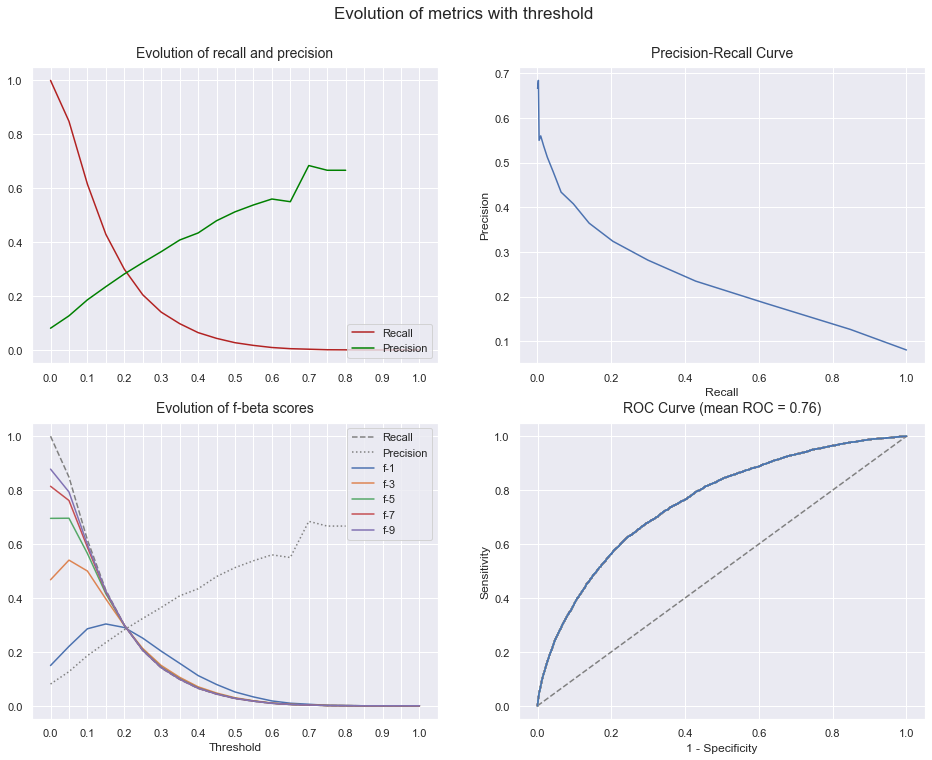

In [17]:
best_lgbm = LGBMClassifier(
    colsample_bytree=0.49660342134693186,
    learning_rate=0.027426794536916214,
    max_depth=3,
    n_estimators=2290,
    num_leaves=509,
    reg_alpha=0.0004374222784475729,
    reg_lambda=3.1655523843003103e-06,
    subsample=0.5251571606455174,
    subsample_freq=3
)

# the threshold wont be used
scores, feature_importance_df, roc_curve_values, probas = test_model(
    X_train_bal,
    y_train_bal,
    X_val,
    y_val,
    model=best_lgbm,
    sample=1.0,
    beta=1,
    threshold=0.5,
    verbose=False
)

show_model_scores(y_val, probas)

## Optimizing SMOTE Balancing

In [8]:
# We are looking for the best oversampling/undersampling combination
# We use a basic LGBM classifier, which is a good model for this problem (tested below)
# Then we will keep the over/under of the best model roc-auc score
over_s = np.arange(0.1, 1.0, 0.2)
all_scores = []

for over_s_param in over_s:
    under_s = np.arange(over_s_param, 1.0, 0.2)
    for under_s_param in under_s:
        print("Testing oversampling {} and undersampling {}".format(over_s_param, under_s_param))
        oversample = imb.over_sampling.SMOTE(sampling_strategy=over_s_param)
        undersample = imb.under_sampling.RandomUnderSampler(sampling_strategy=under_s_param)
        X_train_bal, y_train_bal = oversample.fit_resample(X_train_imb, y_train_imb)
        X_train_bal, y_train_bal = undersample.fit_resample(X_train_bal, y_train_bal)

        lgbm = LGBMClassifier()
        # the threshold wont be used
        scores, feature_importance_df, roc_curve_values, probas = test_model(
            X_train_bal,
            y_train_bal,
            X_val,
            y_val,
            model=lgbm,
            sample=1.0,
            beta=1,
            threshold=0.5,
            verbose=False
        )
        all_scores.append(scores)
        print("Mean ROC = {}".format(np.mean(scores['roc_auc'])))

Testing oversampling 0.1 and undersampling 0.1
Mean ROC = 0.742550796544631
Testing oversampling 0.1 and undersampling 0.30000000000000004
Mean ROC = 0.7419707828631921
Testing oversampling 0.1 and undersampling 0.5000000000000001
Mean ROC = 0.742542939868695
Testing oversampling 0.1 and undersampling 0.7000000000000001
Mean ROC = 0.7386213566056155
Testing oversampling 0.1 and undersampling 0.9000000000000001
Mean ROC = 0.7366450987856086
Testing oversampling 0.30000000000000004 and undersampling 0.30000000000000004
Mean ROC = 0.7366526844850542
Testing oversampling 0.30000000000000004 and undersampling 0.5
Mean ROC = 0.737345247841154
Testing oversampling 0.30000000000000004 and undersampling 0.7
Mean ROC = 0.737180698599152
Testing oversampling 0.30000000000000004 and undersampling 0.8999999999999999
Mean ROC = 0.7366757232347128
Testing oversampling 0.5000000000000001 and undersampling 0.5000000000000001
Mean ROC = 0.7355814832156854
Testing oversampling 0.5000000000000001 and unde

# Evaluating the model
## Comparison to a dummy classifier



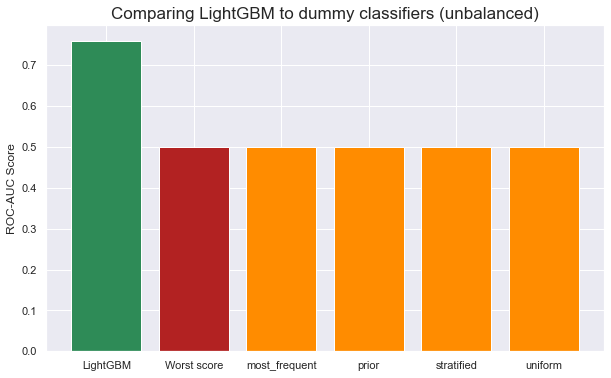

In [18]:
mean_dummy_auc_scores = {
    'LightGBM': 0.76,
    'Worst score': 0.5
}

for strategy in ['most_frequent', 'prior', 'stratified', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    scores, feature_importance_df, roc_curve_values, probas = test_model(
        X_train_imb,
        y_train_imb,
        X_val,
        y_val,
        model=dummy,
        beta=1,
        threshold=0.05,
        verbose=False,
        sample=1.0,
        avoid_features_importances=True
    )
    mean_dummy_auc_scores[strategy] = np.mean(scores['roc_auc'])

plt.figure(figsize=(10, 6))
plt.ylabel("ROC-AUC Score")
plt.title("Comparing LightGBM to dummy classifiers (unbalanced)", fontsize=17)
plt.bar(
    x=mean_dummy_auc_scores.keys(),
    height=mean_dummy_auc_scores.values(),
    color=['seagreen', 'firebrick', 'darkorange', 'darkorange', 'darkorange', 'darkorange']
)
plt.show()

## Testing on Kaggle test dataset

In [22]:
lgbm = LGBMClassifier(
    colsample_bytree=0.49660342134693186,
    learning_rate=0.027426794536916214,
    max_depth=3,
    n_estimators=2290,
    num_leaves=509,
    reg_alpha=0.0004374222784475729,
    reg_lambda=3.1655523843003103e-06,
    subsample=0.5251571606455174,
    subsample_freq=3
)

lgbm.fit(X_train_bal, y_train_bal)
predictions = lgbm.predict_proba(test_df[feats])

# Formatting the output file for Kaggle submission
submission = pd.concat(
    [
        test_df['SK_ID_CURR'].reset_index(),
        pd.DataFrame(predictions)[1],
    ],
    axis=1,
    ignore_index=True
).drop(columns=[0])
submission.columns = ['SK_ID_CURR', 'TARGET']
submission.to_csv('./data/output/submission_kaggle_lgbm.csv', index=False)

## Global Features importances

Text(0.5, 1.0, 'LightGBM Features importances')

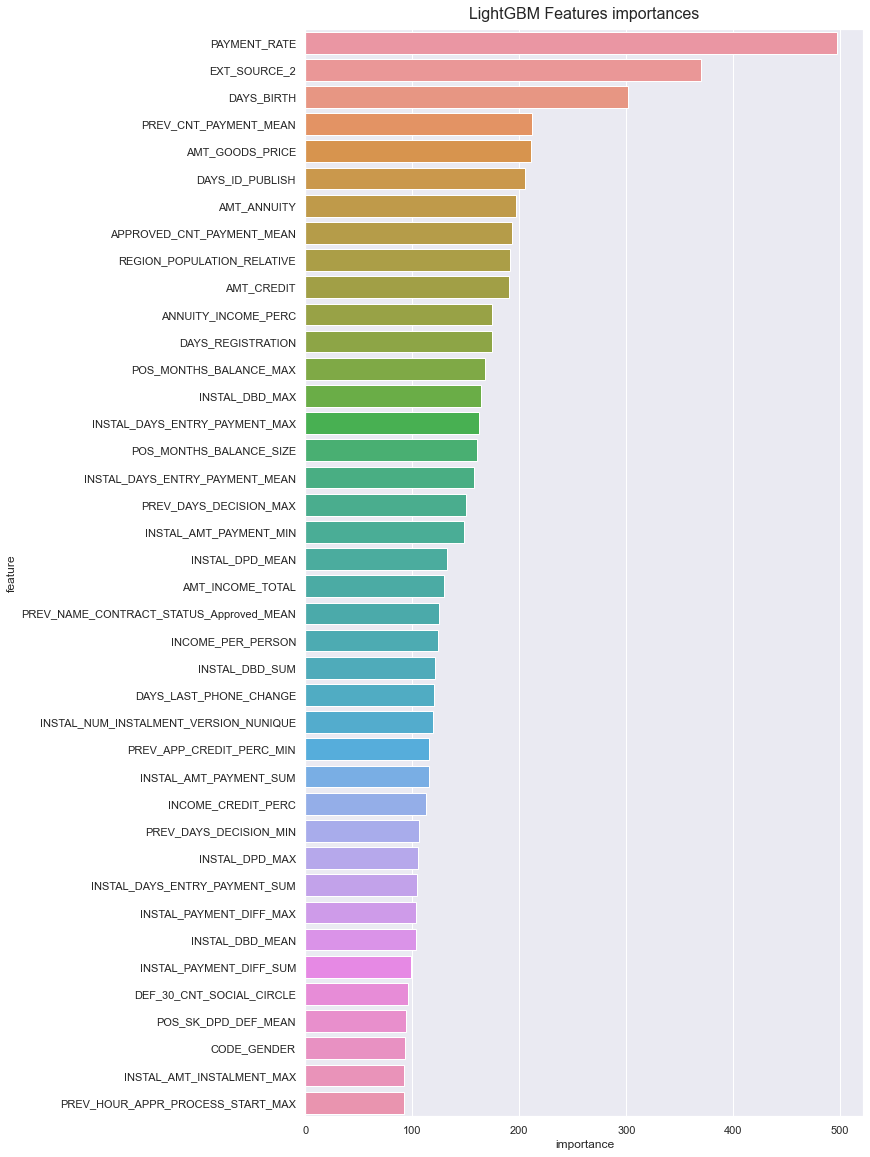

In [32]:
feature_importance_df = pd.DataFrame(
    data={'feature': lgbm.feature_name_, 'importance': lgbm.feature_importances_}
)

plt.figure(figsize=(10, 20))
cols = feature_importance_df[["feature", "importance"]]\
        .groupby("feature")\
        .mean()\
        .sort_values(by="importance", ascending=False)[:40]\
        .index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
sns.barplot(
    x="importance",
    y="feature",
    data=best_features.sort_values(by="importance", ascending=False),
)
plt.title('LightGBM Features importances', fontsize=16, pad=10)

## Local Features importances

In [24]:
lgbm = LGBMClassifier(
    colsample_bytree=0.49660342134693186,
    learning_rate=0.027426794536916214,
    max_depth=3,
    n_estimators=2290,
    num_leaves=509,
    reg_alpha=0.0004374222784475729,
    reg_lambda=3.1655523843003103e-06,
    subsample=0.5251571606455174,
    subsample_freq=3
)
lgbm.fit(X_train_bal, y_train_bal)

explainer = lime_tabular.LimeTabularExplainer(
    X_train_imb.to_numpy(),
    mode="classification",
    class_names=['ACCORDE', 'REFUSE'],
    feature_names=X_train_imb.columns,
)

In [31]:
idx = 100001
explanation = explainer.explain_instance(
    test_df[test_df['SK_ID_CURR'] == idx][feats].iloc[0],
    lgbm.predict_proba,
    num_features=20
)

explanation.show_in_notebook()

## Exporting the model using Pickle

In [ ]:
best_lgbm = LGBMClassifier(
    colsample_bytree=0.49660342134693186,
    learning_rate=0.027426794536916214,
    max_depth=3,
    n_estimators=2290,
    num_leaves=509,
    reg_alpha=0.0004374222784475729,
    reg_lambda=3.1655523843003103e-06,
    subsample=0.5251571606455174,
    subsample_freq=3
)

best_lgbm.fit(X_train_bal, y_train_bal)

pickle.dump(best_lgbm, open('./application/dashboard/model/lgbm.pkl', 'wb'))